In this project, we will use **Vision Transformer (ViT)** for the `Image Classification` task, **ViT** was introduced in [June 2021](https://arxiv.org/abs/2010.11929) by a team of researchers at Google Brain. 

This paper explored how you can `tokenize` images, just as you would tokenize sentences, so that they can be passed to transformer models for training.

1. Split an image into a grid of sub-image patches
2. Embed each patch with a linear projection
3. Each embedded patch becomes a token, and the resulting sequence of embedded patches is the sequence you pass to the model.

In this example post, we'll walk through how to leverage 🤗 datasets to download and process image classification datasets, and then use them to fine-tune a pre-trained ViT with 🤗 transformers.

We will also deploy the demo model on **Hugging Face Spaces** with **Gradio**.

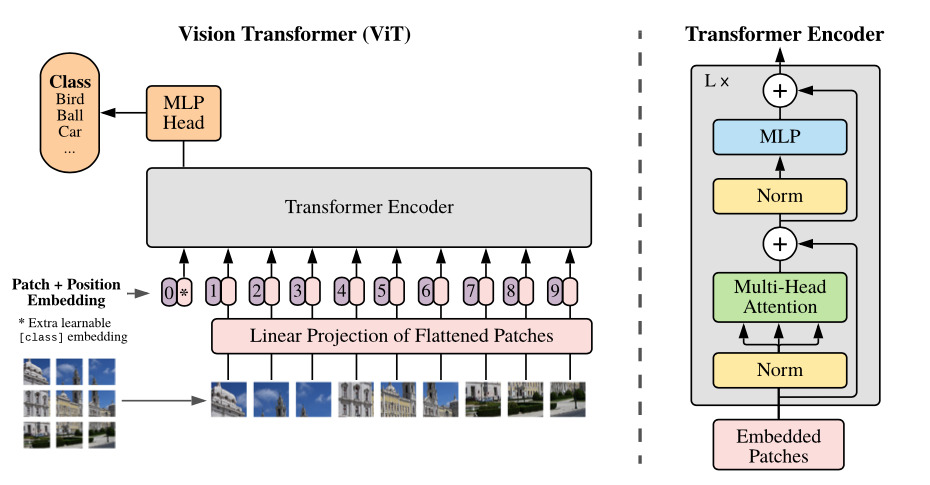

# Import modules

In [49]:
import os, glob
import torch
import math
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from PIL import Image, UnidentifiedImageError
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login

# Load and split data

In [50]:
data_dir = Path('./data')

ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .10)
n_test = math.floor(len(indices) * .10)
train_ds = torch.utils.data.Subset(ds, indices[:-(n_val+n_test)])
val_ds = torch.utils.data.Subset(ds, indices[-(n_val+n_test):-n_test])
test_ds = torch.utils.data.Subset(ds, indices[-n_test:])
print("Train items:", len(train_ds), "Validation items:", len(val_ds), "Test items:", len(test_ds))

Train items: 20945 Validation items: 2617 Test items: 2617


# Visualize some examples

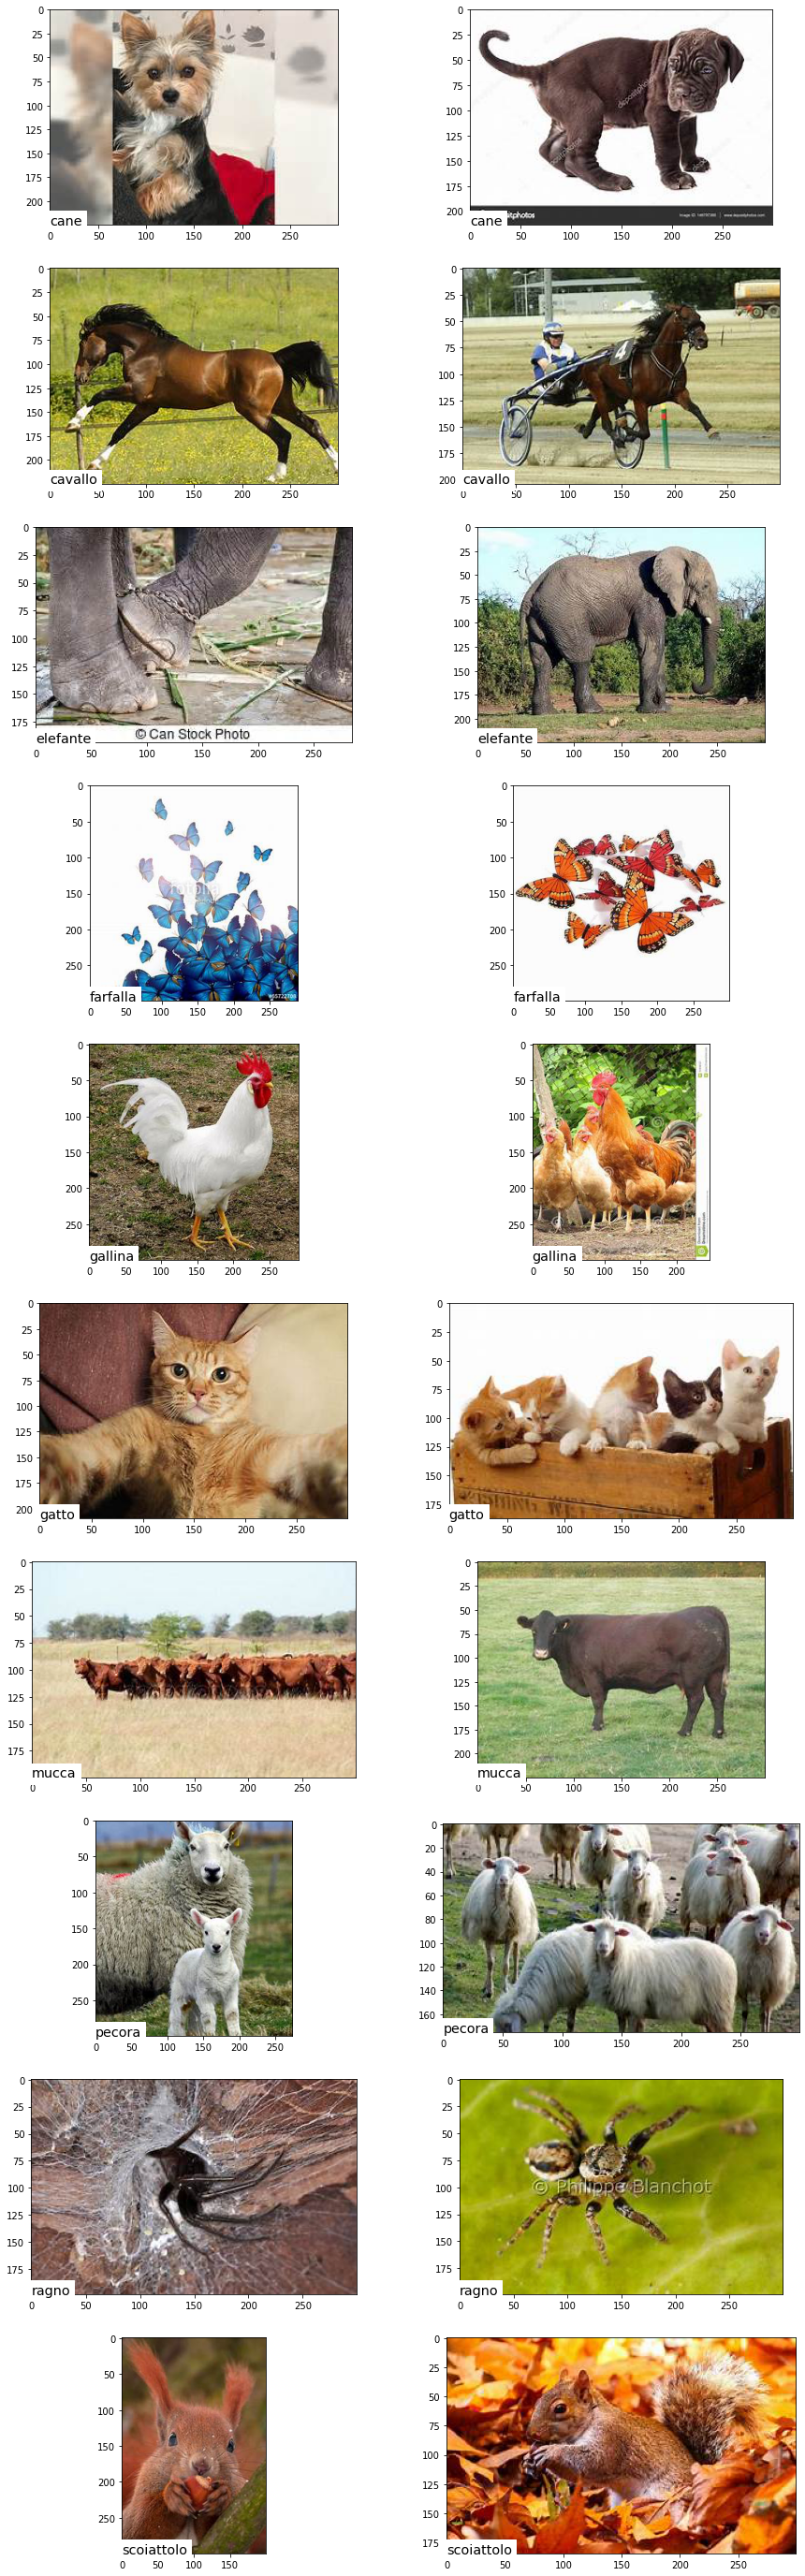

In [66]:
from pathlib import Path

plt.figure(figsize=(15,50))
num_examples_per_class = 2
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
            class_name,
            size='x-large',
            pad=0,
            loc='left',
            y=0,
            backgroundcolor='white'
            )
            ax.axis=('off')
            plt.imshow(image)
            i += 1
            
            if image_idx + 1 == num_examples_per_class:
                break

# Preparing labels for our model's config

By adding `label2id` + `id2label` to our model's config, we'll get friendlier labels in the inference API.

In [69]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

print(label2id)
print(id2label)

{'cane': '0', 'cavallo': '1', 'elefante': '2', 'farfalla': '3', 'gallina': '4', 'gatto': '5', 'mucca': '6', 'pecora': '7', 'ragno': '8', 'scoiattolo': '9'}
{'0': 'cane', '1': 'cavallo', '2': 'elefante', '3': 'farfalla', '4': 'gallina', '5': 'gatto', '6': 'mucca', '7': 'pecora', '8': 'ragno', '9': 'scoiattolo'}


# Image classification collator

To apply our transforms to images, we'll use a custom collator class. We'll initialize it using an instance of `ViTFeatureExtractor` and pass the collator instance to `collate_fn` kwarg in `torch.utils.data.Dataloader`.

In [70]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
        
    def __call__(self, batch):
        excodings = self.feature_extractor([x[0] for x in batch], return_tensor='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings